In [12]:
from numpy import NaN, int64
import math
import pandas as pd
#from sklearn.model_selection import train_test_split #для разделения на тест и трейн
from sklearn.neighbors import KNeighborsRegressor #используемый метод
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error #Оценка качества модели
ss = pd.read_csv('sample_submission.csv')
testDF = pd.read_csv('test_x.csv')
trainDF = pd.read_csv('train.csv')
#trainDF = trainDF.drop(columns = ['rubrics', 'user_city', 'org_city', 'average_bill'], axis = 1)
#testDF = testDF.drop(columns = ['rubrics', 'user_city', 'org_city', 'average_bill'], axis = 1)
#trainDF.hist(bins=50, figsize=(20,30))
#trainDF.info()
#trainDF.describe()
#trainDF.value_counts()
#print(trainDF.shape)
#print(testDF.shape)
CorrKoef = trainDF.corr()
CorField = []
for j in CorrKoef.index[CorrKoef['rating_org'] > 0.08]:
    if 'rating_org' != j and j not in CorField and 'rating_org' not in CorField:
        CorField.append(j)
        #print ('rating_org',j, CorrKoef['rating_org'][CorrKoef.index==j].values[0])
trainDF.head()

,user_id,org_id,rating,ts,user_city,org_city,average_bill,rating_org,rubrics,food_delivery,...,call_button,wheelchair_accessible,table_games,vinotheque,cakes_for_different_occasions,accepted_credit_cards,kalyan,teahouse,bread_from_tandoor,handmade_goods
0,12182789761588196310,11946401375069641937,4.0,677,msk,msk,1500.0,3.883212,Ресторан,1,...,0,0,0,0,0,0,0,0,0,0
1,2796544982129273287,5545859981678495568,5.0,577,msk,msk,1000.0,4.495379,Ресторан,1,...,0,0,0,0,0,0,0,0,0,0
2,10546824832088319728,3451485117888180206,4.0,716,msk,msk,500.0,4.576063,Кафе,1,...,0,0,0,0,0,0,0,0,0,0
3,9967742981458207920,9490041040735762889,3.0,639,spb,spb,1000.0,3.775701,Кафе,1,...,0,0,0,0,0,0,0,0,0,0
4,11046819495825038093,5234254278902729372,5.0,669,msk,msk,500.0,4.187500,Пиццерия,1,...,0,1,0,0,0,0,0,0,0,0


In [13]:
#TRAIN MODIF
cols = [#'user_id',
 #'org_id','rating', 'ts', 'user_city', 'org_city','average_bill', 'rating_org', 'rubrics', 
 'food_delivery', 'breakfast','takeaway', 'summer_terrace', 'wi_fi', 'business_lunch','payment_by_credit_card','coffee_to_go','closed_for_quarantine','online_takeaway', 'karaoke', 'special_menu', 'sports_broadcasts',
 'food_court1', 'craft_beer', 'projector', 'gift_certificate','wheelchair_access', 'automatic_door', 'food_product_delivery','car_park', 'parking_disabled', 'toilet_for_disabled', 'promotions','cafe', 'minimum_order', 'free_delivery', 'self_service_kiosks',
 'has_restaurant', 'air_conditioning', 'pets', 'elevator', 'has_bar','internet access', 'privilege_tickets', 'organic_food', 'vip_zone','hall_capacity', 'face_control', 'show_program', 'music', 'chillout',
 'dancefloor', 'dress_code', 'billiards', 'strip','elevator_wheelchair_accessible', 'ramp', 'around_the_clock_work1', 'pickup', 'farm_products', 'delivery', 'coffee_shop', 'call_button',
 'wheelchair_accessible', 'table_games', 'vinotheque','cakes_for_different_occasions', 'accepted_credit_cards', 'kalyan','teahouse', 'bread_from_tandoor', 'handmade_goods']
#Редкие признаки объединяем в один под названием удобства
new_col = []
for colm in cols :
    if (abs(trainDF[colm].value_counts()[0] - trainDF[colm].value_counts()[1]) > 60000) :
        new_col.append(colm)
new_col2 = new_col
for x in new_col :
    trainDF['breakfast'] = trainDF['breakfast'] + trainDF[x];
trainDF.insert(5, 'udobstva',  trainDF['breakfast']/20);
colsforAnanlys = [
 'user_id',
 'udobstva',
 'org_id', 
 'ts', 
 #'user_city', 
 #'org_city',
 'rating_org', 
 'average_bill'
]
for x in CorField :
    colsforAnanlys.append(x);
trainDF = trainDF[colsforAnanlys]
avg_value = trainDF[~trainDF.average_bill.isna()].average_bill.mean()
trainDF = trainDF.assign(average_bill=trainDF.average_bill.fillna(avg_value)) 
#trainDF = pd.get_dummies(trainDF)
#print(trainDF.ts.max());
trainDF.ts = (1260 - trainDF.ts) / 1260;
trainDF.rating = trainDF.rating;
trainDF = trainDF.drop(columns = ['user_id', 'org_id'], axis = 1)
trainDF.head()

,udobstva,ts,rating_org,average_bill,rating,payment_by_credit_card,sports_broadcasts,craft_beer,projector,gift_certificate,wheelchair_access,automatic_door,car_park,parking_disabled,toilet_for_disabled,cafe,privilege_tickets
0,0.05,0.462698,3.883212,1500.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.00,0.542063,4.495379,1000.0,5.0,1,1,1,1,0,1,1,0,1,1,0,0
2,0.05,0.431746,4.576063,500.0,4.0,1,1,0,0,1,0,0,0,0,0,0,0
3,0.05,0.492857,3.775701,1000.0,3.0,1,1,1,0,0,0,0,0,0,0,0,0
4,0.25,0.469048,4.187500,500.0,5.0,1,0,0,1,0,1,0,0,1,0,0,0


In [14]:
#TEST MODIF
for x in new_col2 :
    testDF['breakfast'] = testDF['breakfast'] + testDF[x];
testDF.insert(5, 'udobstva',  testDF['breakfast']/20);
colsforAnanlys.remove('rating_org')
testDF = testDF[colsforAnanlys]
avg_value = testDF[~testDF.average_bill.isna()].average_bill.mean()
testDF.ts = (1260 - testDF.ts) / 1260;
testDF = testDF.assign(average_bill=testDF.average_bill.fillna(avg_value)) #Очень много нулов на этот признак не стоит полагаться
#testDF = pd.get_dummies(testDF)
trainDF.rating = trainDF.rating;
testDF = testDF.drop(columns = ['user_id', 'org_id'], axis = 1)
testDF.head()


,udobstva,ts,average_bill,rating,payment_by_credit_card,sports_broadcasts,craft_beer,projector,gift_certificate,wheelchair_access,automatic_door,car_park,parking_disabled,toilet_for_disabled,cafe,privilege_tickets
0,0.05,0.401587,1000.000000,5.0,1,0,0,0,0,0,0,0,0,0,0,0
1,0.05,0.921429,1500.000000,5.0,1,1,0,0,0,0,0,0,0,0,0,0
2,0.00,0.068254,500.000000,5.0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.20,0.066667,500.000000,5.0,1,1,0,1,0,0,0,0,0,0,0,0
4,0.15,0.182540,1105.517877,4.0,1,0,0,0,0,0,0,0,0,0,0,0


In [15]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(trainDF)
scaler.fit(testDF)
target_col = 'rating_org'
train_x, train_y = trainDF.drop(columns = ['rating_org', 'rating', 'average_bill'], axis=1), trainDF[target_col]
test_x, test_y = testDF.drop(columns = ['rating', 	'average_bill']), ss[target_col]
model = KNeighborsRegressor(500)
model.fit(train_x, train_y)
pred = model.predict(test_x)
mean_absolute_percentage_error(test_y, pred)


10.859478669414722

In [16]:
ss1 = ss
ss1 = ss.drop(columns = ['rating_org'], axis = 1)
ss1 = ss.assign(rating_org=pred)
ss1.to_csv('submission.csv', index=False)
ss1.head();


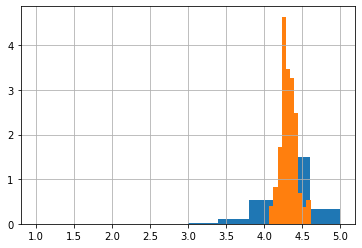

In [21]:
ss11 = pd.read_csv('submission.csv')
#ss['rating_org'].hist()
trainDF['rating_org'].hist(density=True)
ss11['rating_org'].hist(density=True)
ss11.to_csv('submission1.csv', index=False)